In [1]:
import torch
torch.manual_seed(0)

import random
random.seed(0)

import numpy as np
np.random.seed(0)

In [2]:
PRINT_GT = False

In [3]:
def load(fn):
    with open(fn, 'r') as file_in:
        return file_in.read().split('\n')

In [4]:
def repl_t(text):
    text = text.replace('(t1)', '(x1)')
    text = text.replace('(t2)', '(x2)')
    text = text.replace('(t1,t2)', '(x1,x2)')
    return text

In [5]:
id_pairs = [[int(x) for x in l.split('\t')] for l in load('id_pairs_2.txt') if l != '']
sid2uids = {}

for s, u in id_pairs:
    if s not in sid2uids:
        sid2uids[s] = []
    sid2uids[s].append(u)

In [6]:
situations = [[int(l.split('\t')[0]), l.split('\t')[1]] for l in load('situations_2.txt') if l != '']

In [7]:
utterances = [[int(l.split('\t')[0]), l.split('\t')[1]] for l in load('utterances_2.txt') if l != '']

In [8]:
max([len(u[1].split(' ')) for u in utterances])

12

In [9]:
sit2id = {s[1]: s[0] for s in situations}

In [10]:
train_sit = [l.split('\t')[0] for l in load('training_set.txt')]
valid_sit = [l.split('\t')[0] for l in load('test_set.txt')]

In [11]:
train_sit_id = [sit2id[repl_t(s)] for s in train_sit if s != '']
valid_sit_id = [sit2id[repl_t(s)] for s in valid_sit if s != '']

In [12]:
import torch.nn.functional as F
import torch

class Vocab():
    def __init__(self):
        self.vocab = {}
        self.invert = {}
        self.len = 0
    
    def update(self, text, verbose=False):
        for char in text:
            if char not in self.vocab:
                self.vocab[char] = self.len
                self.invert[self.len] = char
                self.len += 1
                if verbose:
                    print('vocab size:', self.len, char)
    
    def tokenize(self, text):
        return torch.tensor([self.vocab[c] for c in text])
    
    def tokenize_oh(self, text):
        return F.one_hot(self.tokenize(text), num_classes=len(self))
    
    def decode(self, ids):
        return [self.invert[x.item()] for x in ids]
    
    def __len__(self):
        return self.len

In [13]:
import re

class PhraseVocab(Vocab):
    def __init__(self):
        self.vocab = {}
        self.invert = {}
        self.len = 0
        self.split_chars = [' ', ')', '(', ',']
        
    def split(self, text):
        for s in self.split_chars:
            text = text.replace(s, self.split_chars[0])
        text_tokens = text.split(self.split_chars[0])
        return text_tokens
    
    def update(self, text, verbose=True):
        text_tokens = self.split(text)
        for token in text_tokens:
            if token not in self.vocab:
                self.vocab[token] = self.len
                self.invert[self.len] = token
                self.len += 1
                if verbose:
                    print('vocab size:', self.len, token)
    
    def tokenize(self, text):
        return torch.tensor([self.vocab[c] for c in self.split(text)])
    
    def tokenize_oh(self, text):
        return F.one_hot(self.tokenize(text), num_classes=len(self))
    
    def decode(self, ids):
        result = []
        
        for x in ids:
            if torch.is_tensor(x):
                x = x.item()
            result.append(self.invert[x])

        return result

In [14]:
type_dict = {
    'shapes': ['ellipse', 'star', 'circle', 'square', 'hexagon', 'triangle']
}

def count_types(text, type_name):
    count = 0
    for tn in type_dict[type_name]:
        count += text.count(tn)
    return count

In [15]:
v1 = PhraseVocab()
v2 = PhraseVocab()
for s in [s[1] for s in situations]:
    v1.update(s)

for u in [u[1] for u in utterances]:
    v2.update(u)

vocab size: 1 bi1
vocab size: 2 x1
vocab size: 3 
vocab size: 4 bl1
vocab size: 5 st1
vocab size: 6 ab2
vocab size: 7 x2
vocab size: 8 me1
vocab size: 9 gr1
vocab size: 10 sq1
vocab size: 11 pu1
vocab size: 12 or1
vocab size: 13 sm1
vocab size: 14 ci1
vocab size: 15 le2
vocab size: 16 tr1
vocab size: 17 re1
vocab size: 18 he1
vocab size: 19 el1
vocab size: 20 ye1
vocab size: 1 the
vocab size: 2 star
vocab size: 3 big
vocab size: 4 blue
vocab size: 5 above
vocab size: 6 medium
vocab size: 7 green
vocab size: 8 square
vocab size: 9 below
vocab size: 10 purple
vocab size: 11 orange
vocab size: 12 small
vocab size: 13 circle
vocab size: 14 to
vocab size: 15 left
vocab size: 16 of
vocab size: 17 triangle
vocab size: 18 right
vocab size: 19 red
vocab size: 20 hexagon
vocab size: 21 ellipse
vocab size: 22 yellow


In [16]:
v2.update('!')
v2.update('^')
v1.update('!')
v1.update('^')

vocab size: 23 !
vocab size: 24 ^
vocab size: 21 !
vocab size: 22 ^


In [17]:
def id_select(ids, targets):
    result = []
    for target_id in ids:
        result.append(targets[target_id - 1][1])
    return result

In [18]:
import torch.nn as nn

class RNNEnc(nn.Module):
    def __init__(self, input_size=300, hidden_size=300):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn_enc = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=1)
        
        #self.lin_input = nn.Linear(30, 128)
        self.embed = nn.Embedding(len(v1), self.input_size)
    
        self.relu = nn.ReLU()
    
        self.enc_lin = nn.Linear(self.hidden_size, self.hidden_size)
    
    def forward(self, x): # seq_length
        x = self.embed(x).unsqueeze(1) # seq_length x 1 x 128
        #x = self.relu(x)
        
        h0 = torch.zeros((1, 1, self.hidden_size))
        
        enc_out, enc_hidden = self.rnn_enc(x, h0)
        # enc_out: seq_length x 1 x 128
        # enc_hidden: 1 x 1 x 128
        
        #enc_out = self.enc_lin(enc_out.squeeze(1))
        #enc_out = self.relu(enc_out) # seq_length x 300
        
        enc_out = enc_out.squeeze(1)
        
        return enc_out, enc_hidden

In [19]:
class RNNDec(nn.Module):
    def __init__(self, embed, input_size=(300), hidden_size=300, max_length=24):
        super().__init__()
        
        self.max_length = max_length
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn_dec = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=1)
        
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.lin_output = nn.Linear(self.hidden_size, len(v2))
        #self.lin_hidden = nn.Linear(256, 128)
        self.embed = nn.Embedding(len(v2), 300)
        
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x, enc_hidden, h, enc_out):
        # x: 1
        # h: 1 x 1 x 300
        x = self.embed(x).reshape(1, -1) # 1 x 300
        x = self.dropout(x)
        
        #enc_hidden = self.lin_hidden(enc_hidden)
        #enc_hidden = self.relu(enc_hidden)
        
        #print(torch.cat((x[0], enc_hidden[0]), dim=1).shape)
        
        attn_weights = F.softmax(self.attn(torch.cat((x, enc_hidden[0]), dim=1)), dim=1) # 1 x max_length
        
        #seq_length = enc_out.shape[0]
        #attn_weights = attn_weights[:, :seq_length] # 1 x seq_length
        
        attn_applied = torch.mm(attn_weights, enc_out) # (1 x seq_length) x (seq_length x 300) = (1 x 300)
        
        rnn_in = torch.cat((x, attn_applied), dim=1)
        rnn_in = self.attn_combine(rnn_in).unsqueeze(0)
        rnn_in = F.relu(rnn_in)
        
        dec_out, dec_hidden = self.rnn_dec(rnn_in, h)
        # dec_out: 1 x 1 x 300
        # dec_hidden: 1 x 1 x 300
        
        logits = self.lin_output(dec_out[0]) # 1 x 30
        
        #probs = self.softmax(logits)
        
        return logits, dec_hidden

In [20]:
from torch import optim

eos_id = v2.tokenize('!')[0]
start_id = v2.tokenize('^')[0]

enc = RNNEnc()
dec = RNNDec(enc.embed)

opt_enc = optim.Adam(enc.parameters(), lr=3e-4)
opt_dec = optim.Adam(dec.parameters(), lr=3e-4)

ce_loss = nn.CrossEntropyLoss()

In [21]:
force_p = [0.0]
def force_p_schedule(epoch_idx):
    if epoch_idx >= len(force_p):
        return force_p[-1]
    return force_p[epoch_idx]

In [22]:
%load_ext autoreload
%autoreload 2

In [23]:
from plotter import Plotter
plot = Plotter()

In [24]:
validspl_sit_id = valid_sit_id
trainspl_sit_id = train_sit_id

In [25]:
from jellyfish import jaro_similarity

In [26]:
def model_forward(input_sit_str, epoch_idx, grad=True, max_length=13):
    input_sit = v1.tokenize(input_sit_str)

    if grad:
        enc_out, enc_hidden = enc(input_sit)
    else:
        with torch.no_grad():
            enc_out, enc_hidden = enc(input_sit)

    pred_ids = []
    pred_logits = []
    
    prev = start_id
    h = enc_hidden
    for i in range(max_length):
        if grad:
            logits, h = dec(prev, enc_hidden, h, enc_out)
        else:
            with torch.no_grad():
                logits, h = dec(prev, enc_hidden, h, enc_out)

        pred = torch.argmax(logits, dim=1)[0]
        prev = pred
        
        pred_ids.append(pred)
        pred_logits.append(logits)
        
        #print(logits[0], tu_target[i])

        #loss += ce_loss(logits, tu_target[i].unsqueeze(0))

        if pred == eos_id:
            break
    
    return pred_ids, pred_logits

In [27]:
class RunningAvg:
    def __init__(self, buffer_size, default=None):
        self.buffer = [default] * buffer_size
        self.idx = 0
        self.buffer_size = buffer_size
    
    def __call__(self, x):
        self.buffer[self.idx % self.buffer_size] = x
        self.idx += 1
        return self.none_avg()
    
    def none_avg(self):
        return sum([b for b in self.buffer if b != None])/self.buffer_size

In [28]:
train_edit_run = RunningAvg(10)
train_loss_run = RunningAvg(10)

In [29]:
from nltk.metrics.distance import edit_distance

def closest_loss(cleaned_pred, pred_logits, target_utters):
    # get label
    utter_dists = [(-edit_distance(t, cleaned_pred), t) for t in target_utters]
    utter_closest = max(utter_dists, key=lambda x:x[0])[1] + ' !'

    if PRINT_GT:
        print(utter_closest, cleaned_pred, '\n')
    
    #print(utter_closest, '|', ' '.join(v.decode(pred_ids)))

    tu_target = v2.tokenize(utter_closest)

    # get loss
    loss = 0.0
    for tkn_idx in range(min(len(pred_logits), len(tu_target))):
        loss += ce_loss(pred_logits[tkn_idx], tu_target[tkn_idx].unsqueeze(0))
    
    return loss, utter_closest

In [30]:
update_every = False
def is_correct(pred, targets):
    if pred in targets and not update_every:
        return 0.0
    return 1.0

  0%|          | 0/18000 [00:00<?, ?it/s]

force_p: 0.0


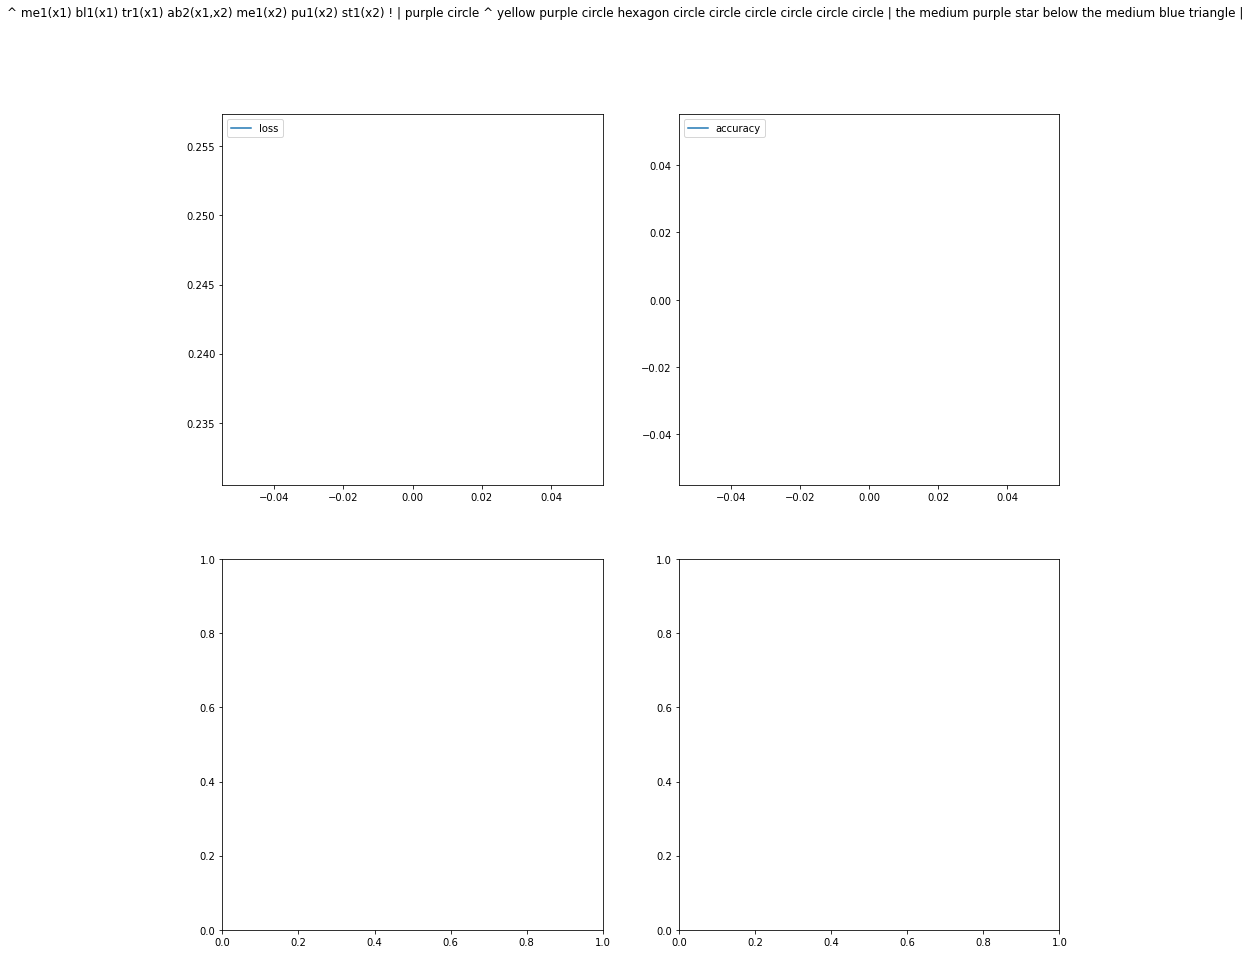

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [31]:
import random
from tqdm.auto import tqdm
from IPython.display import clear_output

stats = []

for epoch_idx in range(1):
    # training
    random.shuffle(trainspl_sit_id)
    pbar = tqdm(enumerate(trainspl_sit_id), total=len(trainspl_sit_id))
    
    print('force_p:', force_p_schedule(epoch_idx))
    
    for i, vals in enumerate(stats):
        print(i, vals)
    
    avg_loss = 0.0
    num_correct = 0
    
    for iter_idx, sit_id in pbar:
        utter_ids = sid2uids[sit_id]
        #print(sit_id, utter_ids)

        target_utters = id_select(utter_ids, utterances)
        
        #tu = random.choice(target_utters) + ' !'
        #tu = min(target_utters, key=lambda u:len(u)) + ' !'
        #tu = max(target_utters, key=lambda u:len(u)) + ' !'
        #tu_target = v.tokenize(tu)
        #print(tu_target)

        input_sit_str = '^ ' + id_select([sit_id], situations)[0] + ' !'
        
        if PRINT_GT:
            print(input_sit_str)
        # model forward
        pred_ids, pred_logits = model_forward(input_sit_str, epoch_idx)
        cleaned_pred = ' '.join(v2.decode(pred_ids)).replace('!', '').strip()
        
        #bleu = sentence_bleu([ref.split(' ') for ref in target_utters], v.decode(pred_ids))
        
        #edit_sim = train_edit_run(jaro_similarity(tu.replace('!', '').strip(), cleaned_pred))
        
        #print('loss: %.3f | "%s" | "%s"' % (loss.item()/len(pred_ids), cleaned_pred, tu.replace('!', '').strip()))
        
        loss, utter_closest = closest_loss(cleaned_pred, pred_logits, target_utters)
        
        avg_loss += loss.item()/len(pred_ids)
        
        plot.add(loss = train_loss_run(loss.item()/len(pred_ids)), accuracy = num_correct/(iter_idx + 1))
        
        if iter_idx % 500 == 0:
            eta = ''
            if pbar.format_dict['rate'] != None:
                eta = (pbar.format_dict['total'] - iter_idx) / pbar.format_dict['rate']
            plot.output_show(suptitle=(input_sit_str + " | " + cleaned_pred + " | " + utter_closest.replace('!', '').strip() + " | " + str(eta)),
                             subplots=(2, 2),
                             figsize=(15, 15))
            #clear_output(wait=True)
        
        if cleaned_pred in target_utters:
            #print('CORRECT')
            num_correct += 1
        else:
            loss.backward()
            opt_dec.step()
            opt_enc.step()

        #loss = is_correct(cleaned_pred, target_utters) * loss

        opt_dec.zero_grad()
        opt_enc.zero_grad()
    
        # validation
        if iter_idx % 500 == 0:
            avg_valid_loss = 0.0
            avg_valid_correct = 0
            avg_valid_edit = 0.0
            avg_valid_comp = 0.0
            
            for iter_idx, sit_id in tqdm(enumerate(validspl_sit_id), total=len(validspl_sit_id)):
                utter_ids = sid2uids[sit_id]

                target_utters = id_select(utter_ids, utterances)

                #tu = random.choice(target_utters) + ' !'
                #tu = min(target_utters, key=lambda u:len(u)) + ' !'
                #tu = max(target_utters, key=lambda u:len(u)) + ' !'
                #tu_target = v.tokenize(tu)

                input_sit_str = '^ ' + id_select([sit_id], situations)[0] + ' !'
                
                if PRINT_GT:
                    print(input_sit_str)
                
                pred_ids, pred_logits = model_forward(input_sit_str, epoch_idx, grad=False)

                cleaned_pred = ' '.join(v2.decode(pred_ids)).replace('!', '').strip()

                #topk_preds = viterbi_predict_topk(input_sit_str, max_length=20, top_k=20)
                #avg_valid_comp += check_completeness(input_sit_str, topk_preds, target_utters)

                #bleu = sentence_bleu([ref.split(' ') for ref in target_utters], v.decode(pred_ids))

                #avg_valid_edit += jaro_similarity(tu.replace('!', '').strip(), cleaned_pred)

                loss, utter_closest = closest_loss(cleaned_pred, pred_logits, target_utters)
                avg_valid_loss += loss.item()/len(pred_ids)

                if cleaned_pred in target_utters:
                    avg_valid_correct += 1

            avg_valid_loss /= len(validspl_sit_id)
            avg_valid_correct /= len(validspl_sit_id)
            avg_valid_edit /= len(validspl_sit_id)
            avg_valid_comp /= len(validspl_sit_id)

            plot.add(valid_accuracy=avg_valid_correct, valid_loss=avg_valid_loss)


In [ ]:
assert False

In [ ]:
import json
import os

DIRECTORY = 'max_ln_fixlbl2_soseos_full_correct_if_3e-4'

if not os.path.isdir(DIRECTORY):
    os.mkdir(DIRECTORY)
#else:
#    raise Exception('Directory already exists')

with open('%s/stats_1.json' % DIRECTORY, 'w') as file_out:
    json.dump(plot.stats, file_out)

with open('%s/out.txt' % DIRECTORY, 'w') as file_out:
    for sit_id in random.choices(validspl_sit_id, k=100):
        utter_ids = sid2uids[sit_id]

        target_utters = id_select(utter_ids, utterances)

        #tu = random.choice(target_utters) + ' !'
        #tu = min(target_utters, key=lambda u:len(u)) + ' !'
        tu = max(target_utters, key=lambda u:len(u)) + ' !'
        tu_target = v2.tokenize(tu)

        input_sit_str = '^ ' + id_select([sit_id], situations)[0] + ' !'

        pred_ids, loss = model_forward(input_sit_str, epoch_idx, grad=False)

        cleaned_pred = ' '.join(v2.decode(pred_ids)).replace('!', '').strip()

        file_out.write('\nTARGET: ' + tu.replace('!', '').strip() + '\n')
        file_out.write('PREDICTION: ' + cleaned_pred + '\n')

#torch.save(enc.state_dict(), '%s/enc.bin' % DIRECTORY)
#torch.save(dec.state_dict(), '%s/dec.bin' % DIRECTORY)

In [ ]:
from top_k_viterbi import viterbi_decode

def predict(input_sit_str, max_length=20):
    input_sit = v1.tokenize(input_sit_str)

    with torch.no_grad():
        enc_out, enc_hidden = enc(input_sit)

    pred_ids = []
    pred_logits = []
    
    prev = start_id
    h = enc_hidden
    for i in range(max_length):
        with torch.no_grad():
            logits, h = dec(prev, enc_hidden, h, enc_out)

        pred = torch.argmax(logits, dim=1)[0]
        prev = pred
        
        pred_ids.append(pred)
        pred_logits.append(logits)
        
        if pred == eos_id:
            break
            
    pred_logits = torch.cat(pred_logits, dim=0)
    
    pred_probs = F.softmax(pred_logits, dim=1)
    
    return pred_probs

def viterbi_predict_topk(input_sit_str, max_length=20, top_k=20):
    probs = predict(situations[0][1])
    num_tags = probs.shape[1]
    
    paths, _ = viterbi_decode(probs, torch.ones((num_tags, num_tags)), top_k=20)

    preds = []
    for p in paths:
        preds.append(' '.join(v2.decode(p)).replace('!', '').strip())
    
    return preds

def check_completeness(situation, model_sentences, utterances):
    """
        This function check if the sentence is valid for the current situation
    :param situation:
    :param model_sentences: List of learner utterances for the current situation
    :param situation_utterance_map:
    :return:
    """

    # Check if the model sentence is within the list of utterances
    correct = 0
    for sentence in utterances:
        if sentence in model_sentences:
            correct += 1

    correct = correct / len(utterances) if len(utterances) > 0 else 0.0

    return correct